Figure generation for a manuscript (using NbN CPW resonator data)
===
by: Faustin W. Carter

(Updated 2018)

Data is from a niobium-nitride CPW resonator fabricated at ANL by Trupti Khaire. It was installed in a copper box, and wirebonded with gold bonds to an impdence matching board that translated the signal from coax to CPW. It is worth noting that the "power" listed in the data is the power at the VNA output in dBm. The signal passes through about 60-70 dB of attenuation on its way down to the resonator, and then experiences between 40-50 dB amplification on the way back up. In other words, the power axis is very much uncalibrated.

The resonator data is available here: <a href="https://doi.org/10.5281/zenodo.61575">DOI:10.5281/zenodo.61575</a>

Import some stuff
---

In [1]:
#Plot options for inline-notebook figures
%matplotlib inline

#this is for retina screens like a MacBook pro
%config InlineBackend.figure_format = 'retina'

#Useful for saving resonator fit data
import os
import pickle

#This is optional, comment out if
#you don't care about covariance plots.
import pygtc

#import the resonator analysis software
import scraps as scr

#Define some resonator names
resNames = ['RES-1', 'RES-2', 'RES-3']

Load the data using the makeResList tool from `scraps`
---
*If you have cached data, skip a few cells down to "Load up previously cached data"*
---
The output is going to be a `dict`, keyword-indexed by the strings in resNames

In [2]:
#Define the path to the data directory
dataPath = '/Users/fcarter/Documents/ANL/Analyses/CPW6_AllData/08222016Res/'

#Make a dict of lists of resonators, one for each name
resLists = {}
for resName in resNames:
    resLists[resName] = scr.makeResList(scr.process_file,
                                        dataPath,
                                        resName,
                                        skiprows=1, delimiter='\t')

Now run fits on the resonator objects

In [3]:
#Loop through the dict, and then through each list and
#run lmfit on each S21 transmission data trace
for resName in resNames:
    for res in resLists[resName]:
        if res.pwr < -60:
            #Apply a filter to the data before 
            #guessing parameters for low-power measuremnts
            res.load_params(scr.cmplxIQ_params,
                            use_filter=True)
        else:
            res.load_params(scr.cmplxIQ_params,
                            use_filter=False)
            
        res.do_lmfit(scr.cmplxIQ_fit)
        #You can uncomment this line to run the
        #MCMC sampler on each resonator.
        #This will probably take several hours.
#         res.do_emcee(scr.cmplxIQ_fit,
#                      nwalkers = 30,
#                      steps = 1000,
#                      burn=200)

Cache fit results for future analysis
---
Once you have run all the fits (which can take 5 or 10 minutes) it is a good idea to cache that data. To do that, run the next cell down. Then, the next time you come back, instead of reloading and refitting all the data, you can just load the cached object back into memory.

In [4]:
#Save resLists to a pickle file for easy loading later.
#This is useful for caching data after you have run fits
#that take a long time.
fName = 'saved_data.pickle'
fPath = os.path.join('./', fName)

with open(fPath, 'wb') as f:
    pickle.dump(resLists, f, 2)

print('last saved file was: '+fName)

last saved file was: saved_data.pickle


Load up previously cached data
---
If you have a .pickle file from a previous run, you can load it up with this cell, and skip everything above except for the first cell that imports modules.

In [2]:
#Load resLists from a pickle file
fName = './saved_data.pickle'
with open(fName, 'rb') as f:
    resLists = pickle.load(f)

Now we can make a plot of the traces.
===

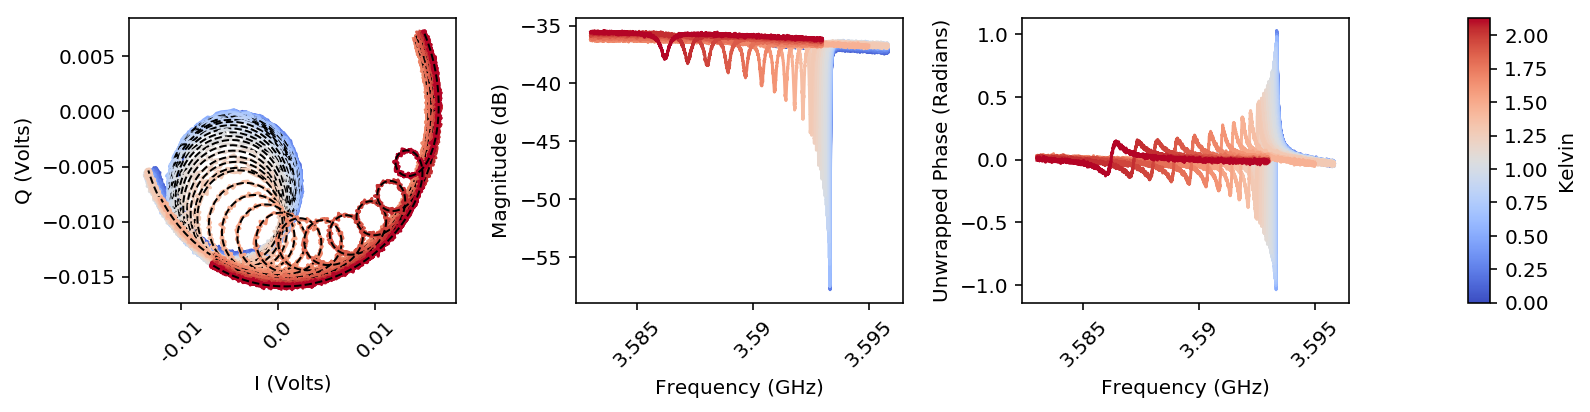

In [3]:
fig1a = scr.plot_tools.plotResListData(resLists['RES-1'],
                            plot_types=['IQ', 'LogMag', 'uPhase'],
                            detrend_phase = True,
                            plot_fits = [True, False, False],
                            color_by='temps',
                            num_cols = 3,
                            fig_size=3,
                            powers = [-55],
                            #the fit defaults to a thick dashed line. Small plots are nicer with a thinner line
                            fit_kwargs={'linestyle':'--', 'color':'k', 'linewidth':1})

#Uncomment to save the figure
#fig1a.savefig('fig1a.pdf')

Use the MCMC sampler to calculate covariances for one of the fits
===
Running this next cell will take a few minutes (5 or 10, maybe)

In [4]:
#Get the index of the resonator at the hottest temperature and
#the lowest power
t_max = max([res.temp for res in resLists['RES-1'] if res.pwr == -65])

#rix just stands for resonator index
rix = scr.indexResList(resLists['RES-1'], t_max, -65)

#Run the MCMC sampler and use the best-fit values from the
#least-squares routine as starting positions
#The first 300 samples from each chain are
#discarded to allow for burn-in
resLists['RES-1'][rix].do_emcee(scr.cmplxIQ_fit,
                                nwalkers = 30,
                                steps = 1000,
                                burn=300)

Use `pygtc` to plot the parameter covariances
---
From here on out, you'll need the `pygtc` package, or a similar package like `corner` to view the covariances.

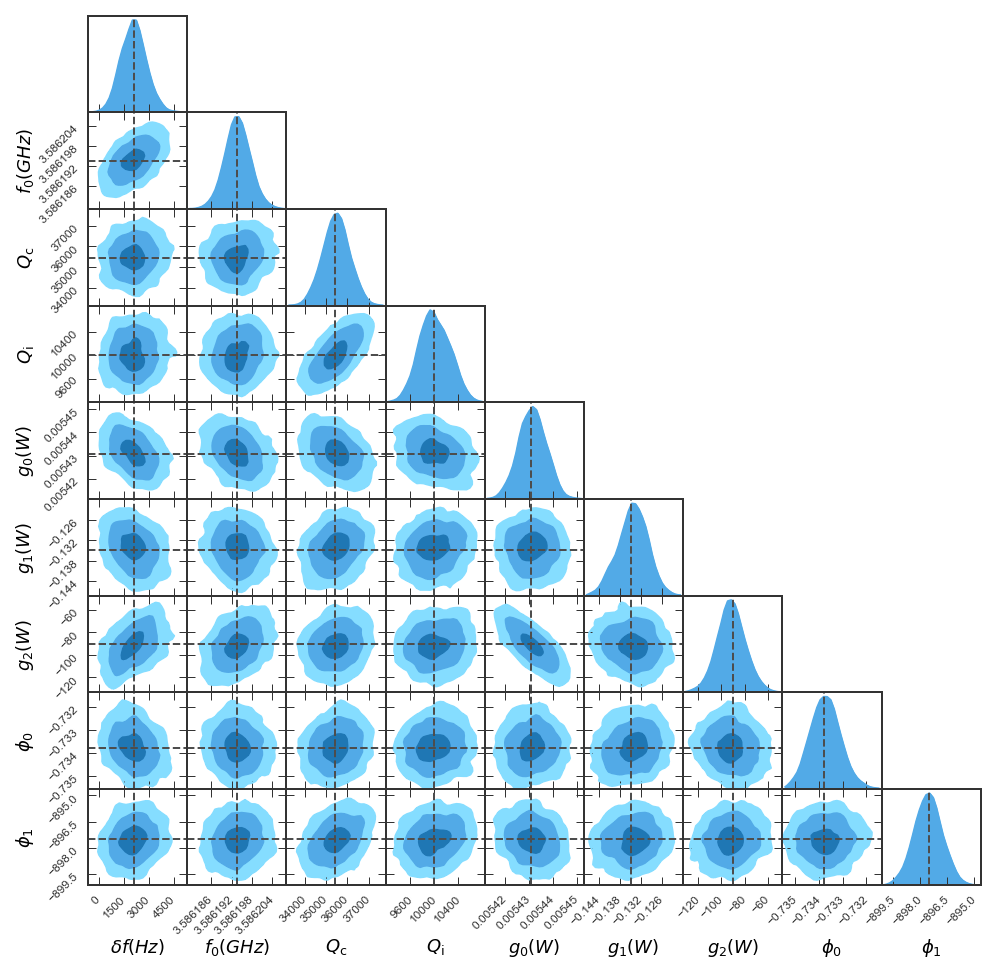

In [5]:
#Make a copy of the MCMC chain so that we
#can modify the units before plotting
mcmc_chain = resLists['RES-1'][rix].chain.copy()

#Change the frequency units from Hz to GHz
mcmc_chain.T.iloc[1]/=1e9

#pygtc will automatically get labels from
#parameter names, but it is nicer to define them
#because we can use LaTex to make them pretty
labels = ['$\delta f (Hz)$',
            '$f_0 (GHz)$',
            '$Q_\mathrm{c}$',
            '$Q_\mathrm{i}$',
            '$g_0 (W)$',
            '$g_1 (W)$',
            '$g_2 (W)$',
            '$\phi_0$',
            '$\phi_1$']

#Copy the best-fit values from the least-squares
#routine so we can modify the units
least_squares_fit_vals = resLists['RES-1'][rix].lmfit_result['default']['values']

#Change the frequency units from Hz to GHz
least_squares_fit_vals[1]/=1e9

#Call pygtc to make the figure
fig1b = pygtc.plotGTC(mcmc_chain,
                       truths=least_squares_fit_vals,
                       paramNames=labels,
                       GaussianConfLevels=True,
                       nConfidenceLevels=3,
                       figureSize=8)

#Uncomment to save the figure
#fig1b.savefig('fig1b.pdf')

S21 fit results vs temperature and power
===
Now, in order to look at the fit parameters as a function of power and/or temperature, we first have to load all the fit parameters into a custom dict of `pandas` DataFrames called a `ResonatorSweep` object. In order for this to work, you'll have to make sure that you are only including data that fits properly into a grid. The `block_check_resList` function can help remove data that is outside of the desired temperature/power grid.

In [6]:
#Define a dict that will hold all the ResonatorSweep objects
#(one for each name).

#Each of these objects will be a dict of pandas DataFrames
#We will ignore anything with a readout power below -70 dBm since
#we happen to know that data is all bad!
resSweeps = {}
for resName, resList in resLists.items():
    resSweeps[resName] = scr.ResonatorSweep([res for res in resList if res.pwr > -70], index='block')

#Look at the uncertainties on the best-fit frequencie
#for the first few files of 'RES-1'
resSweeps['RES-1']['f0_sigma'].head()

,-65.0,-55.0,-45.0,-35.0,-25.0
101.0,241.636656,80.326332,26.967414,12.740956,8.730099
108.0,253.990069,80.906091,27.029754,11.760725,9.538588
117.0,246.129562,79.844324,26.622559,11.756268,9.909033
129.0,243.923856,80.745320,26.860808,12.573795,8.546415
143.0,248.637777,82.198278,27.060582,11.976298,9.268566


Now we can look at the fit parameters from the previous step vs Temperature or Power
---

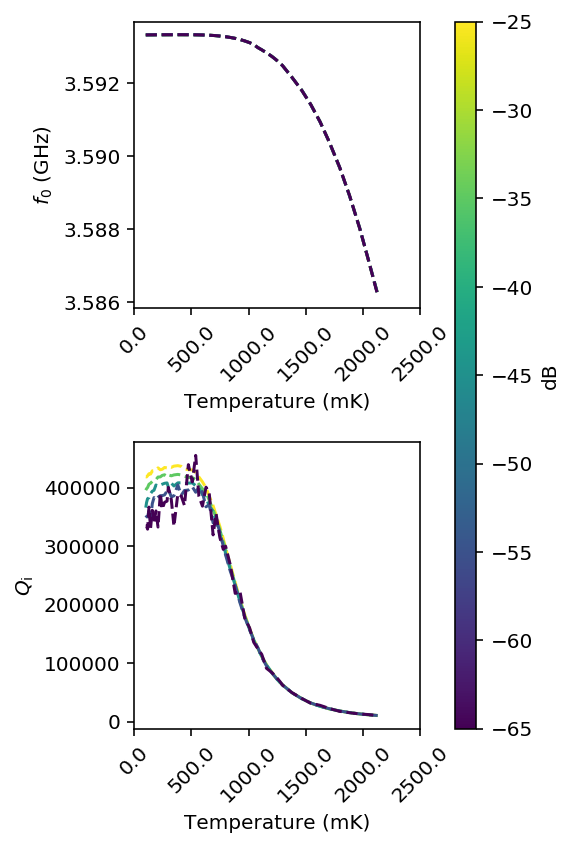

In [7]:
fig1c = scr.plotResSweepParamsVsX(resSweeps['RES-1'],
                                    xvals = 'temperature',
                                    fig_size = 3,
                                    plot_keys = ['f0', 'qi'],
                                    plot_labels = ['$f_0$ (GHz)',
                                                   '$Q_\mathrm{i}$'],
                                    unit_multipliers = [1e-9, 1],
                                    num_cols = 1,
                                    powers = [-25, -35, -45, -55, -65],
                                    force_square=True)
#Uncomment to save the figure
#fig1c.savefig('fig1c.pdf')

Fitting secondary fit parameters to a model
===
Now we will fit the frequency as a function of temperature and power to a model and use the MCMC sampler to calculate the parameter covariances for that fit.

Generate model parameters
---
Since `scraps` doesn't have any models for secondary parameter fitting built in (except for a very simple toy model, which we will use) we need to specify some parameters and starting guesses.

In [8]:
import lmfit as lf

f0_params = lf.Parameters()

#Resonant frequency at zero temperature and zero power
f0_guess = resSweeps['RES-1']['f0'].iloc[0, 0]
f0_params.add('f0',
              value = f0_guess,
              min = f0_guess*0.95,
              max = f0_guess*1.05)

#The loss roughly equivalent to tan delta
f0_params.add('Fd',
              value = 1e-6,
              min = 1e-8)

#The kinetic inductance fraction
f0_params.add('alpha',
              value = 0.005,
              min = 0,
              max = 1)

#The BCS energy gap at zero temperature
f0_params.add('delta0',
              value = 5e-4,
              min = 1e-5,
              max = 1e-3,)

#Qi needs all of the above parameters, plus a few more
qi_params = f0_params.copy()

#Q at zero power and zero temperature
qi_params.add('q0',
              value = 4e5,
              min = 1e4,
              max = 1e6)

#Critical power in W (modulo some calibration)
qi_params.add('Pc',
              value = 4,
              min = 0,
              max = 10000)

#Set the max temperature to fit to
max_fit_temp = 800

Run the fit with the toy model
---
Here we are using the toy model included in `scraps.fitsSweep.f0_tlsAndMBT`. It is definitely not physically valid (except for maybe aluminum), and low weight should be placed on the value of the fit parameters generated. However, it captures the overall character of the data, and so it is useful as an example.

First we run an individual fit on two of the surfaces: $f_0$ and $Q_\mathrm{i}$.

In [9]:
resSweeps['RES-1'].do_lmfit(['qi'],
                            [scr.fitsSweep.qi_tlsAndMBT], #The model
                            [qi_params], #The paramters
                            min_pwr=-70, #S21 fits below -70 were bad
                            max_temp=max_fit_temp)

resSweeps['RES-1'].do_lmfit(['f0'],
                            [scr.fitsSweep.f0_tlsAndMBT], #The model
                            [f0_params], #The paramters
                            min_pwr=-70, #S21 fits below -70 were bad
                            max_temp=max_fit_temp)

#Uncomment to look at the results of the fit
#lf.report_fit(resSweeps['RES-1'].lmfit_results['qi'])

Plot the results as a surface
---
We use the 3D plotting functionality to look at the fit (black-dashed mesh) overplotted on the semi-transparent surface that is the data.

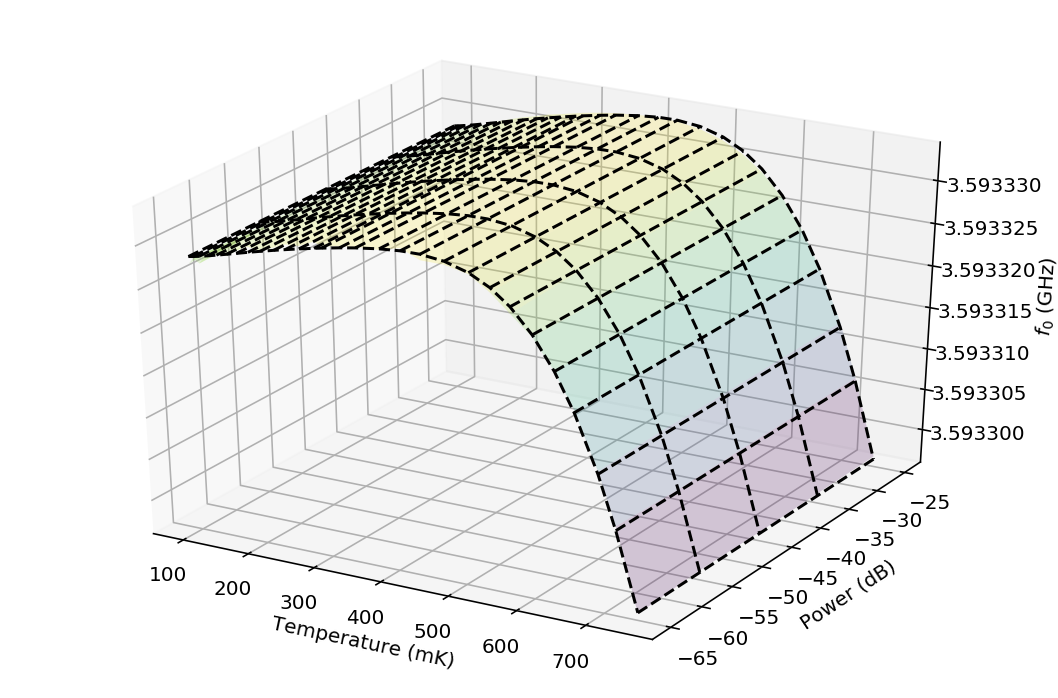

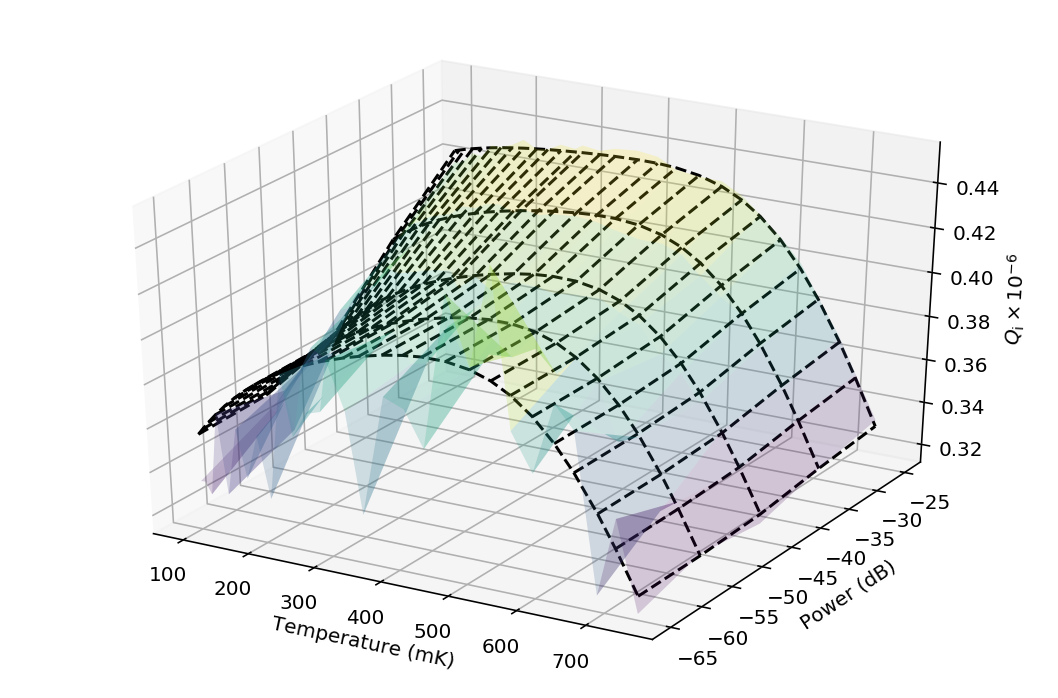

In [10]:
fig2a = scr.plotResSweep3D(resSweeps['RES-1'],
                           plot_keys=['f0'],
                           max_temp=775,
                           unit_multipliers=[1e-9],
                           plot_labels = ['$f_0$ (GHz)'],
                           min_pwr=-70,
                           fig_size=5,
                           plot_lmfits=True)

fig2b = scr.plotResSweep3D(resSweeps['RES-1'],
                           plot_keys=['qi'],
                           max_temp=775,
                           unit_multipliers=[1e-6],
                           plot_labels = ['$Q_\mathrm{i}\\times10^{-6}$'],
                           min_pwr=-70,
                           fig_size=5,
                           plot_lmfits=True)

#When the tick labels are really long, it's nice to push them out a little
#So they don't overlap with the label. This will be automatically handled
#in a future version.
fig2a.axes[0].tick_params(axis='z', pad=8)
fig2a.axes[0].zaxis.labelpad = 13

#Save figures
#fig2a.savefig('fig2a.pdf')
#fig2b.savefig('fig2b.pdf')

Use MCMC to look at the fit parameter covariances
---
Running this next cell will take a few minutes.

In [11]:
resSweeps['RES-1'].do_emcee(['f0'],
                            [scr.fitsSweep.f0_tlsAndMBT],
                            min_pwr=-70,
                            max_temp=max_fit_temp,
                            emcee_kwargs = {'nwalkers':100,
                                            'steps':1000,
                                            'burn':300})

resSweeps['RES-1'].do_emcee(['qi'],
                            [scr.fitsSweep.qi_tlsAndMBT],
                            min_pwr=-70,
                            max_temp=max_fit_temp,
                            emcee_kwargs = {'nwalkers':100,
                                            'steps':1000,
                                            'burn':300})

/Users/fcarter/anaconda/envs/py36/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/fcarter/anaconda/envs/py36/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


Use `pygtc` to plot the parameter covariances
---
As before, we'll use `pygtc` to look at the parameter covariances. The black dashed lines are the best-fit values from the least-squares routine. It is nice to scale the numerical values before plotting, so as before, we will do that.

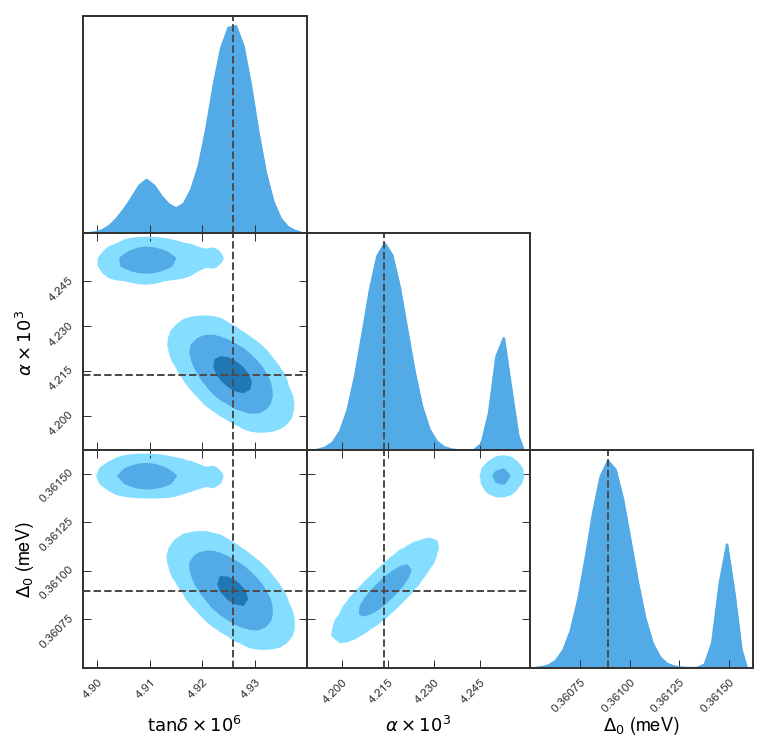

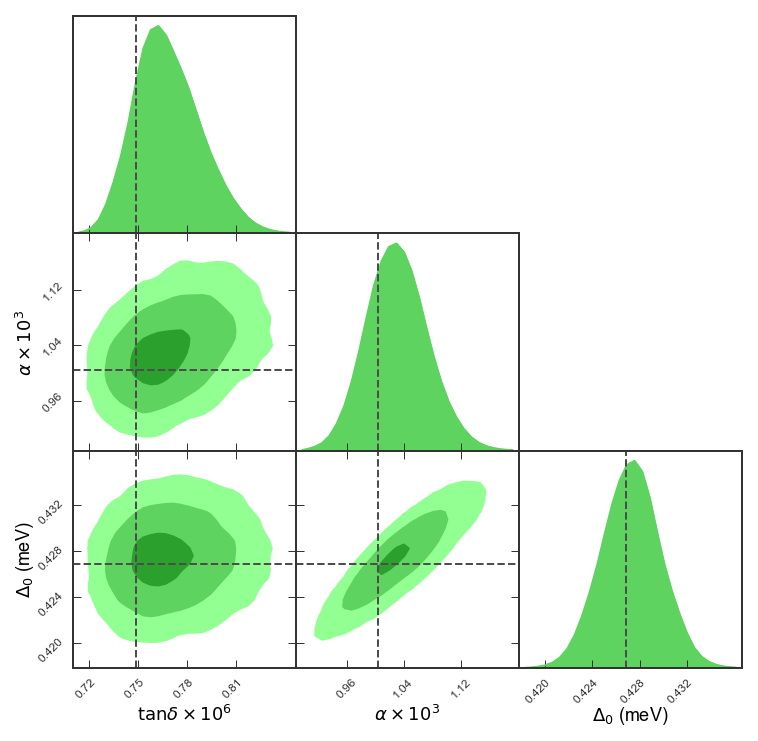

In [12]:
#Get the resulting MCMC chain for the 'f0' fit
f0_mcmc_chain = resSweeps['RES-1'].emcee_results['f0'].flatchain.copy()

#Grab the best-fit values from the least-squares run
f0_lmfit_truths = [val for key, val in 
    resSweeps['RES-1'].lmfit_results['f0'].params.valuesdict().items()]

#Scale the parameters for nicer viewing
mults = [1e9, 1e-6, 1e-3, 1e-3]

for ix, m in enumerate(mults):
    f0_mcmc_chain.T.iloc[ix]/=m
    f0_lmfit_truths[ix]/=m

#Make some nicer labels than just the parameter keys
f0_labels = ['$f_0 (GHz)$',
             '$\\tan \delta\\times10^{6}$',
             '$\\alpha\\times10^{3}$',
             '$\Delta_0$ (meV)']

#Call pygtc to plot the figure
fig2c = pygtc.plotGTC(f0_mcmc_chain.iloc[:,1:],
                        truths = f0_lmfit_truths[1:],
                        paramNames=f0_labels[1:],
                        GaussianConfLevels=True,
                        nConfidenceLevels=3,
                        figureSize=6)

#Save figure
#fig2c.savefig('fig2c.pdf')

#Get the resulting MCMC chain for the 'qi' fit
qi_mcmc_chain = resSweeps['RES-1'].emcee_results['qi'].flatchain.copy()

#Grab the best-fit values from the least-squares run
qi_lmfit_truths = [val for key, val in 
    resSweeps['RES-1'].lmfit_results['qi'].params.valuesdict().items()]

#Scale the parameters for nicer viewing
mults = [1e9, 1e-6, 1e-3, 1e-3, 1e6, 1e-6]

for ix, m in enumerate(mults):
    qi_mcmc_chain.T.iloc[ix]/=m
    qi_lmfit_truths[ix]/=m

#Make some nicer labels than just the parameter keys
qi_labels = ['$f_0 (GHz)$',
             '$\\tan \delta\\times10^{6}$',
             '$\\alpha\\times10^{3}$',
             '$\Delta_0$ (meV)',
            '$Q_\mathrm{i}(0)\\times10^{-6}$',
            '$P_\mathrm{c}$ ($\mu$W)']

#Call pygtc to plot the figure
fig2d = pygtc.plotGTC(qi_mcmc_chain.iloc[:,1:4],
                        truths = qi_lmfit_truths[1:4],
                        paramNames=qi_labels[1:4],
                        GaussianConfLevels=True,
                        nConfidenceLevels=3,
                        figureSize=6,
                        colorsOrder = 'greens')


#Save figure
#fig2d.savefig('fig2d.pdf')

Joint fit of $f_0$ and $Q_\mathrm{i}$.
---

It is possible to run a joint fit also. However, this will likely not add very much information given that the shared parameters disagree by amounts much larger than their variance between the two fits. In any case, here is a joint fit demonstrated for completeness.

In [17]:
#Run the joint fit using the least-squares engine
resSweeps['RES-1'].do_lmfit(['f0', 'qi'],
                            [scr.fitsSweep.f0_tlsAndMBT, scr.fitsSweep.qi_tlsAndMBT], #The model
                            [f0_params, qi_params], #The paramters
                            min_pwr=-70, #S21 fits below -70 were bad
                            max_temp=max_fit_temp)

Now calculate the parameter covariances with MCMC.

In [18]:
resSweeps['RES-1'].do_emcee(['f0', 'qi'],
                            [scr.fitsSweep.f0_tlsAndMBT, scr.fitsSweep.qi_tlsAndMBT],
                            min_pwr=-70,
                            max_temp=max_fit_temp,
                            emcee_kwargs = {'nwalkers':100,
                                            'steps':1000,
                                            'burn':300})

And look at the result with `pygtc`. It's pretty clear that the 'qi' part of the fit is dominating the results for whatever reason. Probably this has to do with 1. not scaling the uncertainties correctly and 2. not using compatible models for $Q_\mathrm{i}$ and $f_0$.

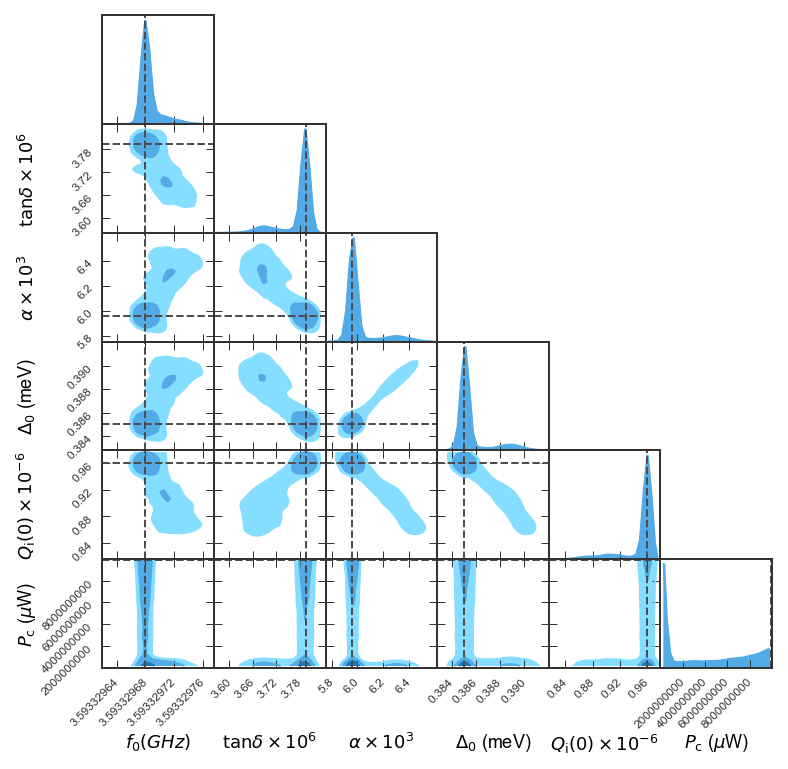

In [19]:
#Get the resulting MCMC chain for the 'qi' fit
f0qi_mcmc_chain = resSweeps['RES-1'].emcee_joint_results['f0+qi'].flatchain.copy()

#Grab the best-fit values from the least-squares run
f0qi_lmfit_truths = [val for key, val in 
    resSweeps['RES-1'].lmfit_joint_results['f0+qi'].params.valuesdict().items()]

#Scale the parameters for nicer viewing
mults = [1e9, 1e-6, 1e-3, 1e-3, 1e6, 1e-6]

for ix, m in enumerate(mults):
    f0qi_mcmc_chain.T.iloc[ix]/=m
    f0qi_lmfit_truths[ix]/=m

#Make some nicer labels than just the parameter keys
f0qi_labels = ['$f_0 (GHz)$',
             '$\\tan \delta\\times10^{6}$',
             '$\\alpha\\times10^{3}$',
             '$\Delta_0$ (meV)',
            '$Q_\mathrm{i}(0)\\times10^{-6}$',
            '$P_\mathrm{c}$ ($\mu$W)']

#Call pygtc to plot the figure
fig2d = pygtc.plotGTC(f0qi_mcmc_chain,
                        truths=f0qi_lmfit_truths,
                        paramNames=f0qi_labels,
                        GaussianConfLevels=True,
                        nConfidenceLevels=3,
                        figureSize=6)

Finally, let's look at the joint fits as surfaces on top of the actual data. It's no surprise after looking at the corner plot above that the values they return are not actually a very good fit to the data! It's probably time to get a better model than the toy included here!

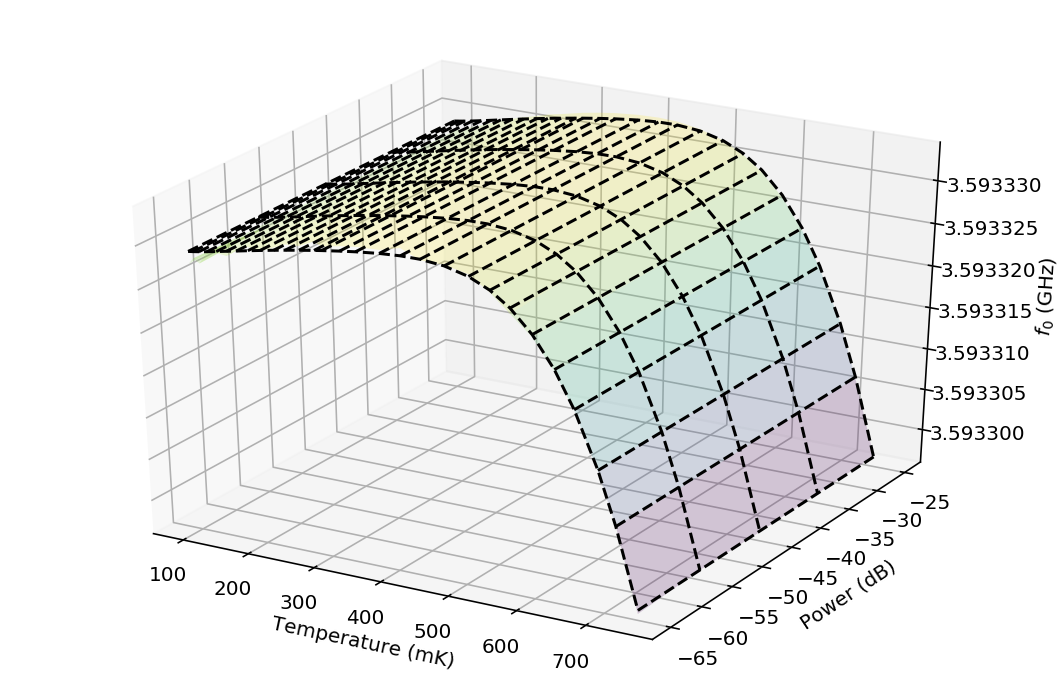

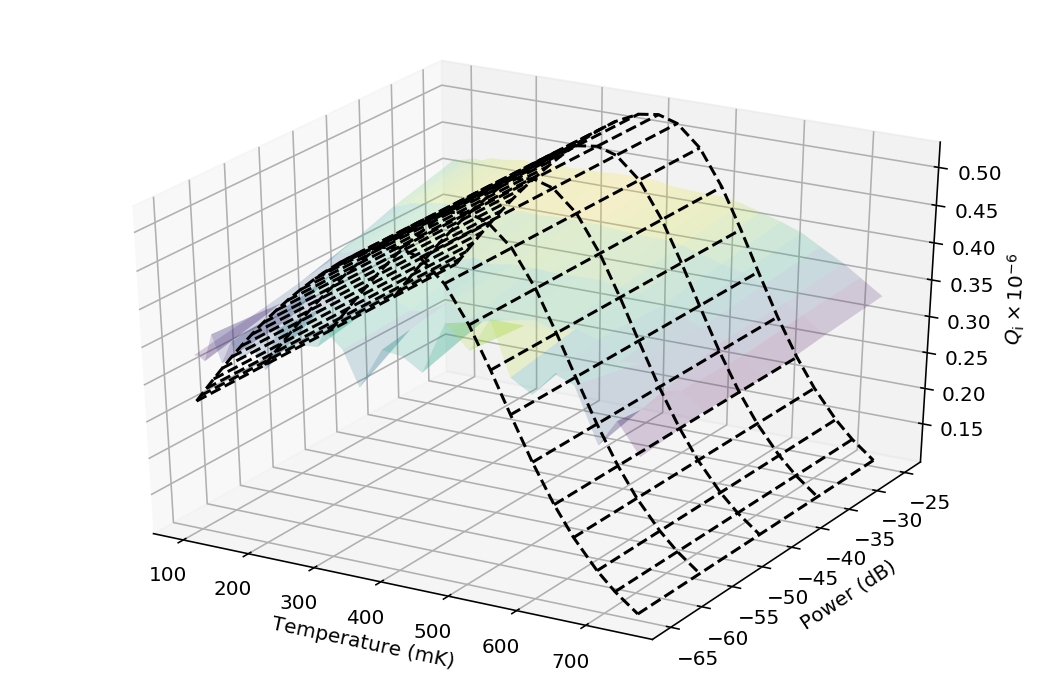

In [20]:
fig2e = scr.plotResSweep3D(resSweeps['RES-1'],
                           plot_keys=['f0'],
                           max_temp=775,
                           unit_multipliers=[1e-9],
                           plot_labels = ['$f_0$ (GHz)'],
                           min_pwr=-70,
                           fig_size=5,
                           plot_fits=['lmfit_joint_f0+qi'])

fig2f = scr.plotResSweep3D(resSweeps['RES-1'],
                           plot_keys=['qi'],
                           max_temp=775,
                           unit_multipliers=[1e-6],
                           plot_labels = ['$Q_\mathrm{i}\\times10^{-6}$'],
                           min_pwr=-70,
                           fig_size=5,
                           plot_fits=['lmfit_joint_f0+qi'])

#When the tick labels are really long, it's nice to push them out a little
#So they don't overlap with the label. This will be automatically handled
#in a future version.
fig2e.axes[0].tick_params(axis='z', pad=8)
fig2e.axes[0].zaxis.labelpad = 13